# MORINGA DATA SCIENCE PHASE 3 Project

Before delving into the details of the project, it is important to clarify which dataset was used. There was an option of 5 different standard datasets that were provided [here](https://drive.google.com/drive/u/4/folders/15bI18N2wQXF11C-CE3ihul_DD7axSQwK), or one had the option of selecting your own dataset. 

I chose to use the [SyriaTel Customer Churn dataset](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset/data).

## **Preliminaries**

To begin with, all the relevant packages are imported at the very beginning to ensure no packages that are used are missing.

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn import tree
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier,BaggingRegressor,GradientBoostingClassifier,GradientBoostingRegressor

from imblearn.over_sampling import SMOTE

As the concepts of Object-Oriented Programming are now more familiar, the code required to manipulate the data we receive will be split into four classes: 
1. Data Sourcing
2. Data PreProcessing
3. Data Analysis
4. Model Deployment

The classes themselves, along with their respective functions, are listed below. It is crucial that each of the cells is run in order to ensure that there are no errors.

In [15]:
class DataSourcing:
  def __init__(self,dataframe):
    self.original = dataframe
    self.dataframe = dataframe
  
  def give_info(self):
    message =  f"""
    ----------------------------------------------------------------------->
    DESCRIPTION OF THE DATAFRAME IN QUESTION:
    ----------------------------------------------------------------------->
    
    Dataframe information => {self.dataframe.info()}
    ------------------------------------------------------------------------------------------------------------------------->
    
    Dataframe shape => {self.dataframe.shape[0]} rows, {self.dataframe.shape[1]} columns
    ------------------------------------------------------------------------------------------------------------------------->    
    
    There are {len(self.dataframe.columns)} columns, namely: {self.dataframe.columns}.  
    ------------------------------------------------------------------------------------------------------------------------->
        
    The first 5 records in the dataframe are seen here:
    ------------------------------------------------------------------------------------------------------------------------->
    {self.dataframe.head()}
    ------------------------------------------------------------------------------------------------------------------------->
       
    The last 5 records in the self.dataframe are as follows: 
    ------------------------------------------------------------------------------------------------------------------------->
    {self.dataframe.tail()}
    ------------------------------------------------------------------------------------------------------------------------->
    
    The descriptive statistics of the dataframe (mean,median, max, min, std) are as follows:
    ------------------------------------------------------------------------------------------------------------------------->
    {self.dataframe.describe()}
    ------------------------------------------------------------------------------------------------------------------------->
    """
    print (message)
  
  def null_count(self):
    return self.dataframe.isnull().sum()

In [16]:
class DataPreProcessing(DataSourcing):
  def __init__(self, dataframe):
    super().__init__(dataframe)

  def dropColumns(self, columns):
    return self.dataframe.drop(columns, axis=1)

  def dropRows(self, rows):
    return self.dataframe.drop(rows, axis=0)

  def preprocess_data(self):            

    # Calculate total calls
      self.dataframe["total_calls"] = self.dataframe["total day calls"] + self.dataframe["total night calls"] + self.dataframe["total eve calls"] + self.dataframe["total intl calls"]

    # Calculate total minutes
      self.dataframe["total_minutes"] = self.dataframe["total day minutes"] + self.dataframe["total night minutes"] + self.dataframe["total eve minutes"] + self.dataframe["total intl minutes"]

    # Calculate total charges
      self.dataframe["total_charges"] = self.dataframe["total day charge"] + self.dataframe["total night charge"] + self.dataframe["total eve charge"] + self.dataframe["total intl charge"]

    # Drop unnecessary columns
      self.dataframe.drop(columns=["total day calls", "total night calls", "total eve calls", "total intl calls",
                     "total day minutes", "total night minutes", "total eve minutes", "total intl minutes",
                              "total day charge", "total night charge", "total eve charge", "total intl charge"],
                     inplace=True)
      return self.dataframe
    
  def one_hot_encode(self):
    # Creating One-Hot Encoder
    ohe = OneHotEncoder(drop="first", sparse_output=False)
    
    # Selecting dataframe with desired columns to OHE
    df = self.dataframe[['international plan', 'churn', 'voice mail plan']].copy()
    # Specifying dataframe without OHE columns
    df_dropped = self.dataframe.drop(columns=['international plan', 'churn', 'voice mail plan']).copy()
    
    # Encoding categorical columns and transferring them into a df
    data_cat_ohe = pd.DataFrame(data=ohe.fit_transform(df), columns=[f"{col}_{cat}" for col in df.columns for cat in ohe.categories_[0][1:]])

    # Adding to original dataframe
    self.dataframe = pd.concat([df_dropped,data_cat_ohe],axis=1)
    return self.dataframe

In [17]:
class DataAnalysis(DataPreProcessing, DataSourcing):
    def __init__(self,dataframe):
        super().__init__(dataframe)

    def univariate_analysis(self):

        numeric_columns = self.dataframe.select_dtypes(include=['number']).columns
        categorical_columns = self.dataframe.drop(
            columns=['phone number']).select_dtypes(exclude=['number']).columns
        # Plot histograms and box plots for numeric columns
        for column in numeric_columns:

            plt.figure(figsize=(12, 6))

            # Plot histogram
            plt.subplot(1, 2, 1)
            sns.histplot(self.dataframe[column], bins=30, kde=True)
            plt.title(f'Histogram for {column}')

            # Plot box plot
            plt.subplot(1, 2, 2)
            sns.boxplot(x=self.dataframe[column])
            plt.title(f'Box Plot for {column}')

            plt.show()

        # Plot count plots for categorical columns
        for column in categorical_columns:
            plt.figure(figsize=(12, 6))

            # Plot count plot
            sns.countplot(x=self.dataframe[column])
            plt.title(f'Count Plot for {column}')

            plt.show()

    def bivariate_analysis(self, column_of_interest):

        numeric_columns = self.dataframe.select_dtypes(include=['number']).columns
        categorical_columns = self.dataframe.drop(
            columns=['phone number']).select_dtypes(exclude=['number']).columns

        numeric_columns = self.dataframe.select_dtypes(include='number').columns

        for column in numeric_columns:
            # Plot histplot
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            sns.histplot(
                x=self.dataframe[column], hue=self.dataframe[column_of_interest], bins=30, kde=True)
            plt.title(f'Histplot for {column} by {column_of_interest}')

        # Plot box plot
            plt.subplot(1, 2, 2)
            sns.boxplot(x=self.dataframe[column_of_interest], y=self.dataframe[column])
            plt.title(f'Box Plot for {column_of_interest} by {column}')

            plt.show()

        # Plot count plots for categorical columns
        for outer in categorical_columns:

            plt.figure(figsize=(12, 6))

            # Plot count plot
            sns.scatterplot(x=self.dataframe[outer], y=self.dataframe["churn"])
            plt.title(f'Count Plot for churn vs.{outer}')

            plt.show()

    def churn_by_state(self):
        self.dataframe.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)) 

    def churn_by_area_code(self):
        self.dataframe.groupby(["area code", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5))

    def churn_by_int_plan(self):
        self.dataframe.groupby(["international plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

    def churn_by_vm_plan(self):
        self.dataframe.groupby(["voice mail plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

In [18]:
# TODO - Remember to consider over/under sampling when training the model



class Modeling(DataPreProcessing):
    def __init__(self,dataframe):
        super().__init__(dataframe)
    
    def label_encoder(self):
        le = LabelEncoder()
        self.dataframe["churn"] = le.fit_transform(self.dataframe["churn"])
        self.dataframe['state'] = le.fit_transform(self.dataframe['state'])
        self.dataframe['area code'] = le.fit_transform(self.dataframe['area code'])
        self.dataframe['international plan'] = le.fit_transform(self.dataframe['international plan'])
        self.dataframe['voice mail plan'] = le.fit_transform(self.dataframe['voice mail plan'])
        return self.dataframe

    def smote(self,X_train,y_train):
        # X = self.dataframe.drop(columns=["churn", "phone number"], axis=1)
        # y = self.dataframe["churn"]
        
        sm = SMOTE(k_neighbors=5, random_state=123)
        X_train_over, y_train_over = sm.fit_resample(X_train, y_train)
        print('Before OverSampling, the shape of X_train: {}'.format(X_train.shape))
        print('Before OverSampling, the shape of y_train: {}'.format(y_train.shape)) 
        print('After OverSampling, the shape of X_train_over: {}'.format(X_train_over.shape))
        print('After OverSampling, the shape of y_train_over: {}'.format(y_train_over.shape))

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)

        # Display confusion matrix as a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d",
                    cmap="Blues", annot_kws={"size": 16})
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()
        return cm

    def scale_data(self,var_to_scale):
        scaler = StandardScaler()
        var_scaled = scaler.fit_transform(var_to_scale)
        return var_scaled
    
    def evaluate_model(self,X_test,y_test,model):
        y_pred = model.predict(X_test)
        
        score = model.score(X_test, y_test)
        con_mat = self.plot_confusion_matrix(y_test, y_pred)
        # con_mat = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        return score,y_pred, con_mat, report
    
    def train_test_split(self, target_class, test_size=0.2, random_state=42):
        X = self.dataframe.drop(columns=["churn", "phone number"], axis=1)
        y = self.dataframe["churn"]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y)
        return X_train, X_test, y_train, y_test

    def logistic(self, X_train, X_test, y_train, y_test):
        X_train_scaled = self.scale_data(X_train)
        X_test_scaled = self.scale_data(X_test)
        
        model = LogisticRegression()
        model.fit(X_train_scaled, y_train)
        
        score, y_pred, con_mat, report = self.evaluate_model(X_test_scaled, y_test, model)
        
        print(f"""
              <-------- Logistic Regression Results --------->
              Accuracy : {round(score*100,4)}%
              
              Confusion Matrix : {con_mat}
              
              Classification Report :
              {report}
              """)
        return score,con_mat,report

    def decision_tree(self, X_train, X_test, y_train, y_test):
        X_train_scaled = self.scale_data(X_train)
        X_test_scaled = self.scale_data(X_test)

        model = DecisionTreeClassifier()
        model.fit(X_train_scaled, y_train)

        score, y_pred, con_mat, report = self.evaluate_model(
            X_test_scaled, y_test, model)

        print(f"""
              <-------- Decision Tree Results --------->
              Accuracy : {round(score*100, 4)}%

              Confusion Matrix : {con_mat}

              Classification Report :
              {report}
              """)
        return score, con_mat, report

    def random_forest(self, X_train, X_test, y_train, y_test):
        X_train_scaled = self.scale_data(X_train)
        X_test_scaled = self.scale_data(X_test)

        model = RandomForestClassifier()
        model.fit(X_train_scaled, y_train)

        score, y_pred, con_mat, report = self.evaluate_model(
            X_test_scaled, y_test, model)

        print(f"""
              <-------- Random Forest Results --------->
              Accuracy : {round(score*100, 4)}%

              Confusion Matrix : {con_mat}

              Classification Report :
              {report}
              """)
        return score, con_mat, report

    def hyperparameter_tuning(self, X_train, X_test, y_train, y_test):
        model = RandomForestClassifier()
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        grid_search = GridSearchCV(model, param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        score = best_model.score(X_test, y_test)
        return score

## **1. DATA UNDERSTANDING**

The identification, gathering, and cursory analysis of the data in this part will be carried out by:

- gathering preliminary data, which has been put into a CSV file.
- describing the data that we have at our disposal.
- looking for patterns and correlations in the data.
- confirming the accuracy of the data.

Firstly, to open the dataset provided, we will utilise pandas rather than any specific class. This is because the classes take a dataframe as a positional argument, and pandas provides several methods for opening different kinds of data files.

In [19]:
df_raw = pd.read_csv('./data/telecom.csv')

Now that we have a dataframe of our dataset, we can pass that dataframe to our `DataSourcing` class and begin the process of data understanding.

In [20]:
data_sourcing = DataSourcing(dataframe=df_raw)
data_sourcing.give_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [21]:
data_sourcing.null_count()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [22]:
data_prep = DataPreProcessing(dataframe=data_sourcing.dataframe)
data_prep.preprocess_data()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,customer service calls,churn,total_calls,total_minutes,total_charges
0,KS,128,415,382-4657,no,yes,25,1,False,303,717.2,75.56
1,OH,107,415,371-7191,no,yes,26,1,False,332,625.2,59.24
2,NJ,137,415,358-1921,no,no,0,0,False,333,539.4,62.29
3,OH,84,408,375-9999,yes,no,0,2,False,255,564.8,66.80
4,OK,75,415,330-6626,yes,no,0,3,False,359,512.0,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,2,False,292,660.7,60.10
3329,WV,68,415,370-3271,no,no,0,3,False,239,585.4,63.53
3330,RI,28,510,328-8230,no,no,0,2,False,264,675.6,67.74
3331,CT,184,510,364-6381,yes,no,0,2,False,336,517.6,57.53


In [23]:
# data_prep.one_hot_encode()

In [24]:
data_prep.dataframe

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,customer service calls,churn,total_calls,total_minutes,total_charges
0,KS,128,415,382-4657,no,yes,25,1,False,303,717.2,75.56
1,OH,107,415,371-7191,no,yes,26,1,False,332,625.2,59.24
2,NJ,137,415,358-1921,no,no,0,0,False,333,539.4,62.29
3,OH,84,408,375-9999,yes,no,0,2,False,255,564.8,66.80
4,OK,75,415,330-6626,yes,no,0,3,False,359,512.0,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,2,False,292,660.7,60.10
3329,WV,68,415,370-3271,no,no,0,3,False,239,585.4,63.53
3330,RI,28,510,328-8230,no,no,0,2,False,264,675.6,67.74
3331,CT,184,510,364-6381,yes,no,0,2,False,336,517.6,57.53


# **2. Exploratory Data Analysis**

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


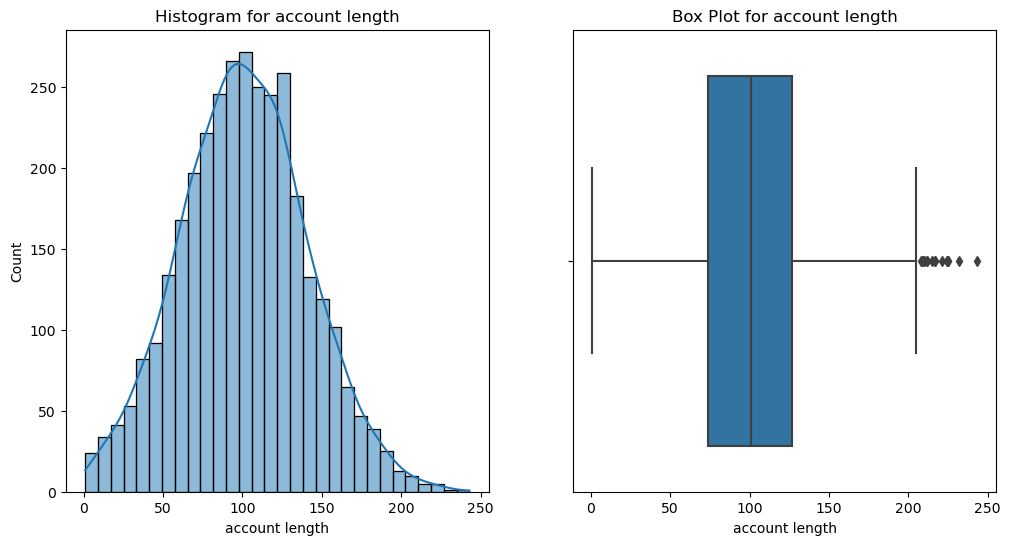

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


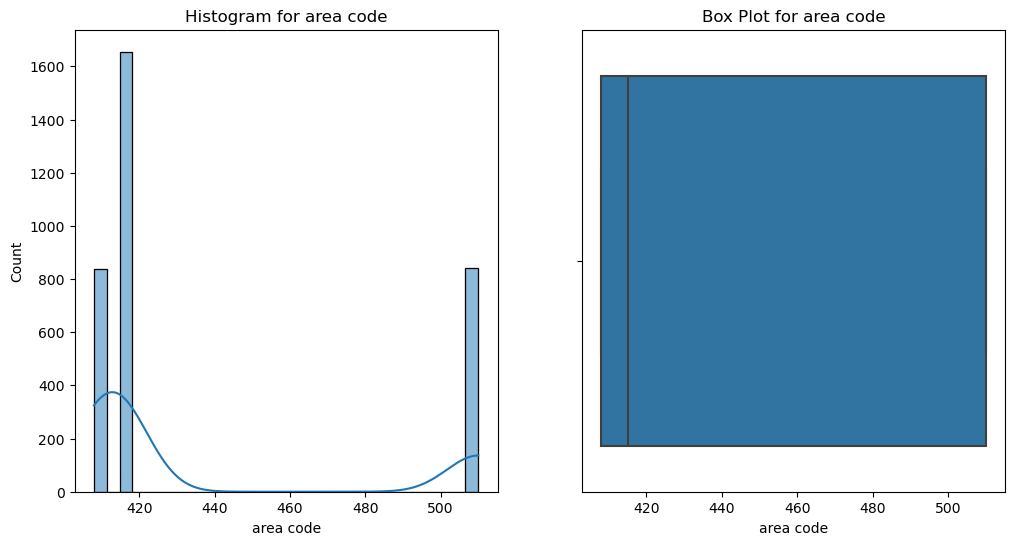

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


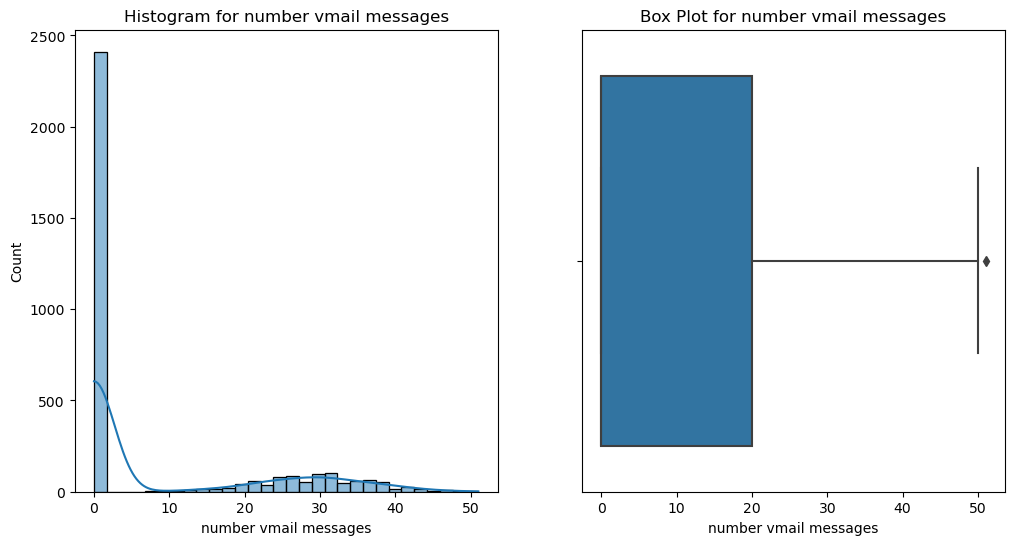

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


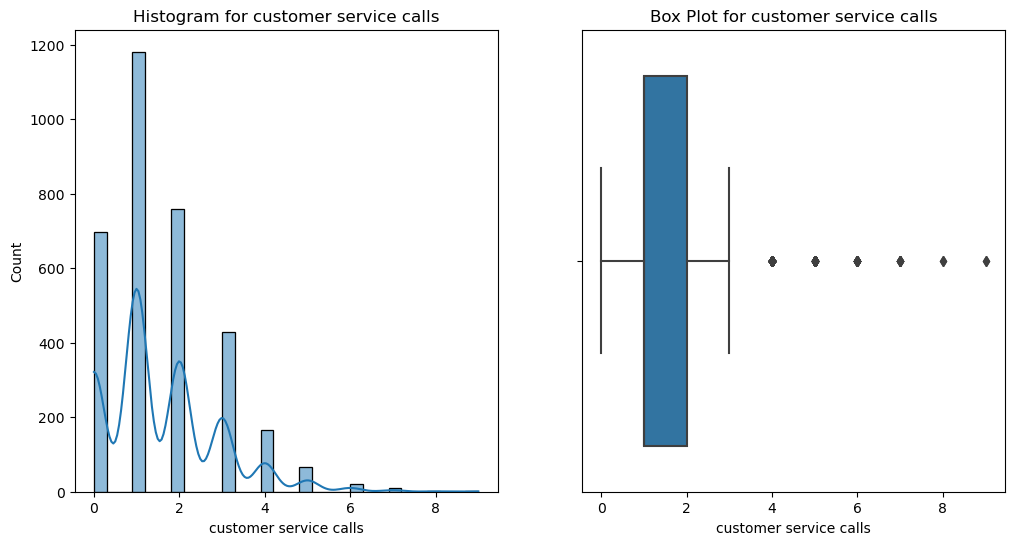

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


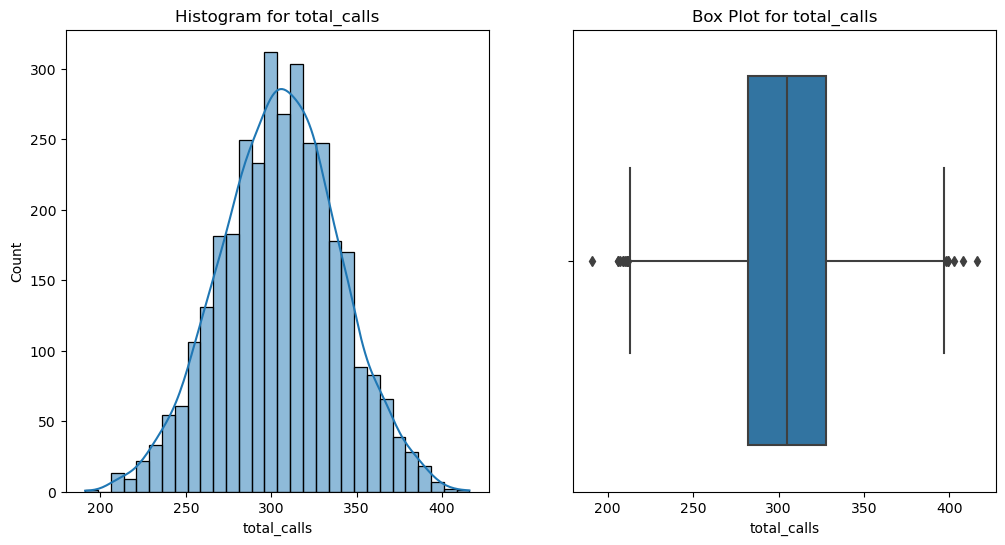

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


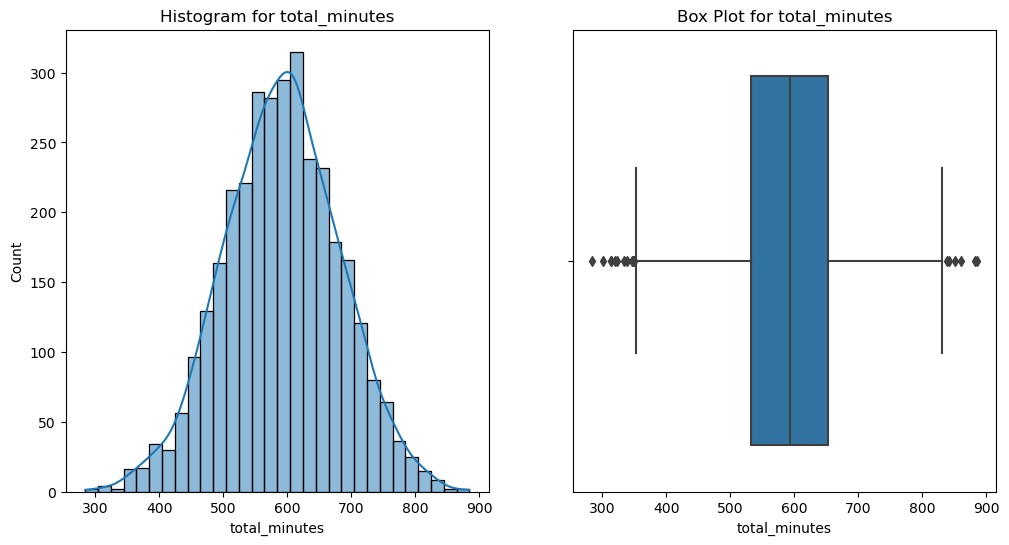

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


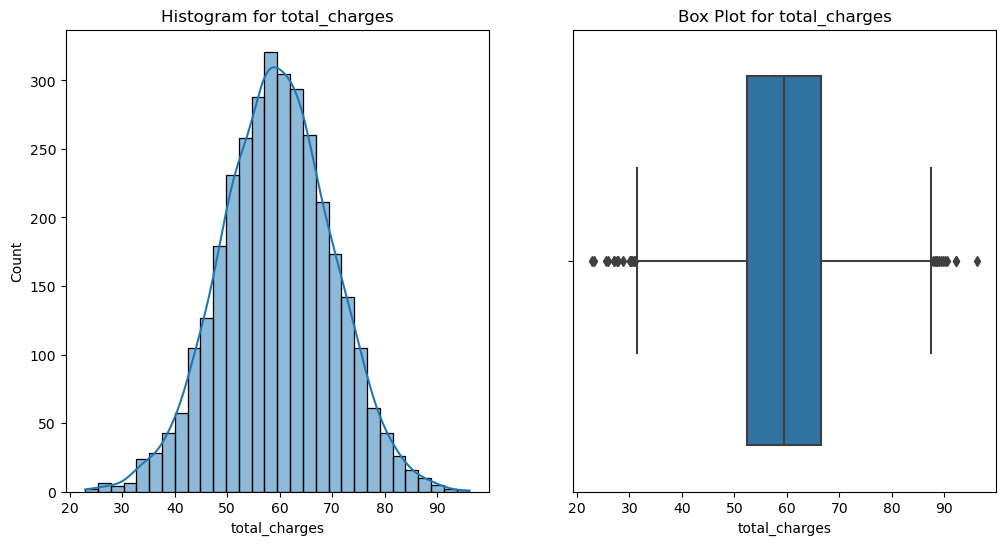

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


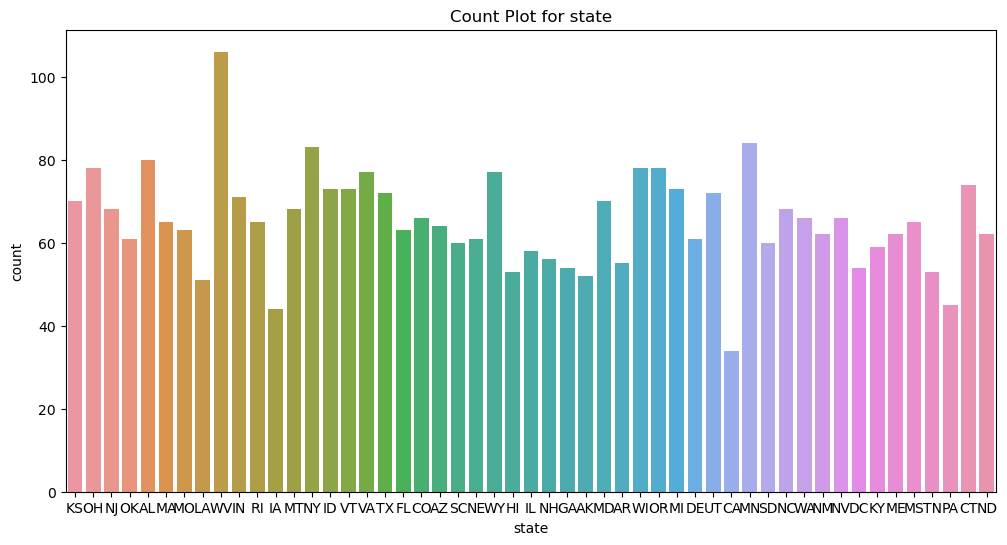

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


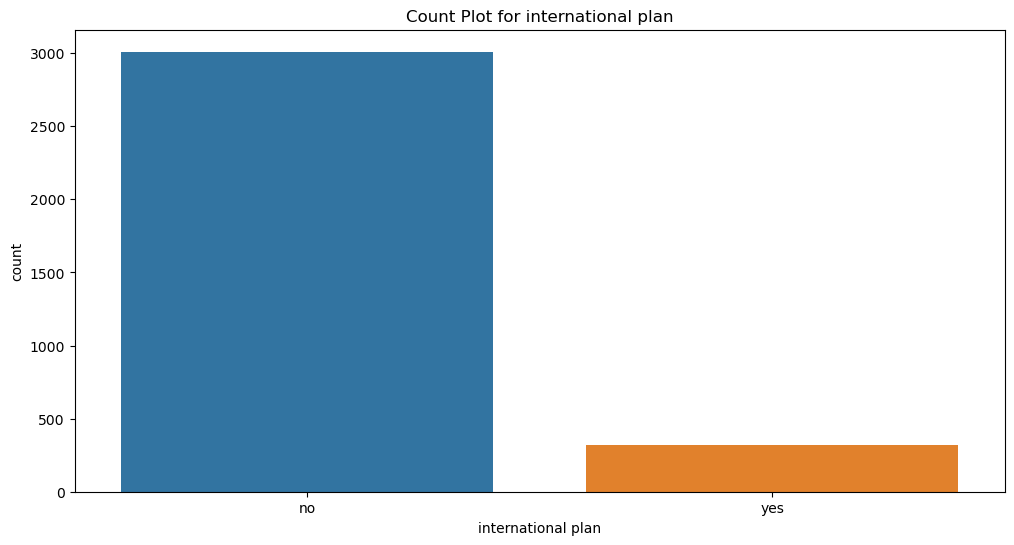

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


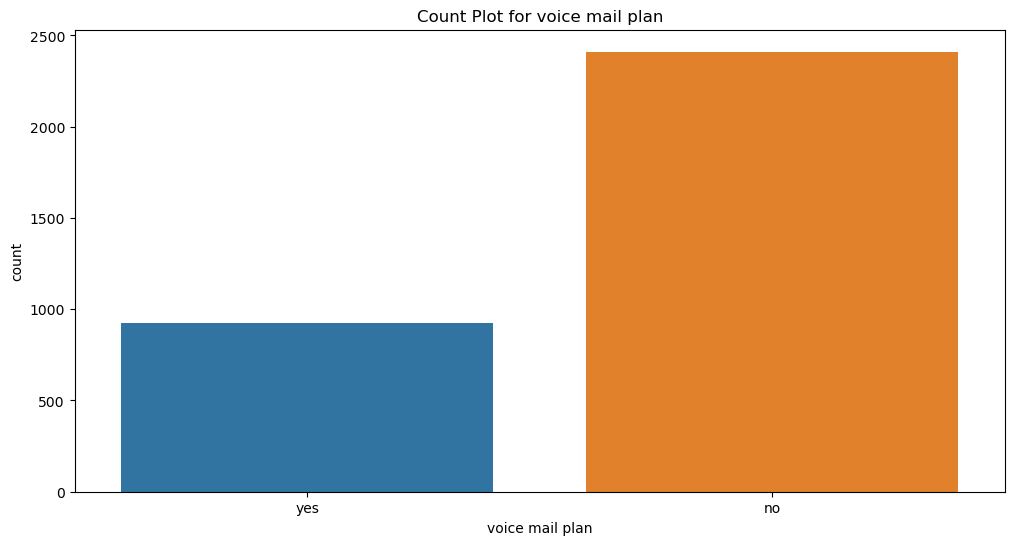

e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\anaconda3\envs\mwiti-base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


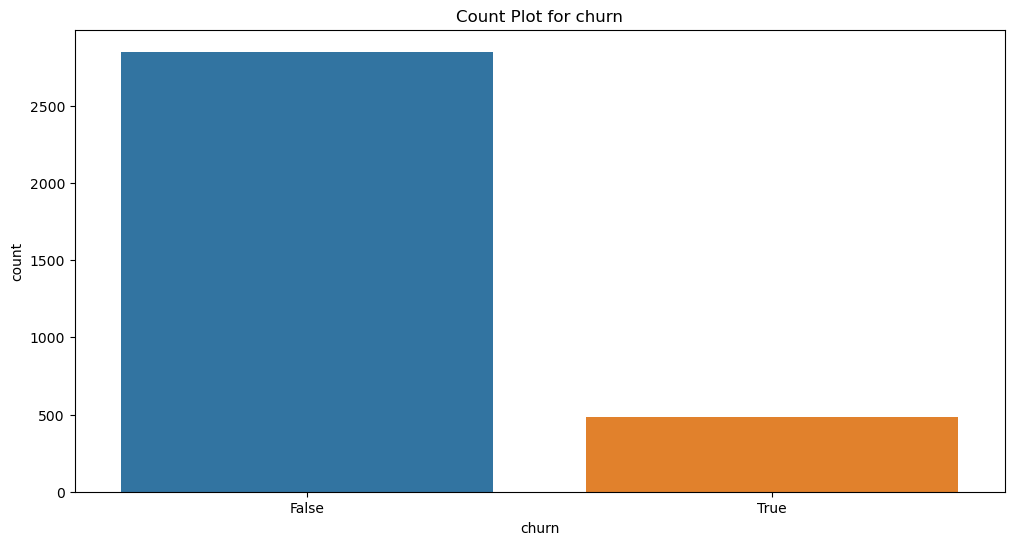

In [25]:
data_analysis = DataAnalysis(dataframe=data_prep.dataframe)
data_analysis.univariate_analysis()

## **3. Modelling**

Before OverSampling, the shape of X_train: (2666, 10)
Before OverSampling, the shape of y_train: (2666,)
After OverSampling, the shape of X_train_over: (4560, 10)
After OverSampling, the shape of y_train_over: (4560,)


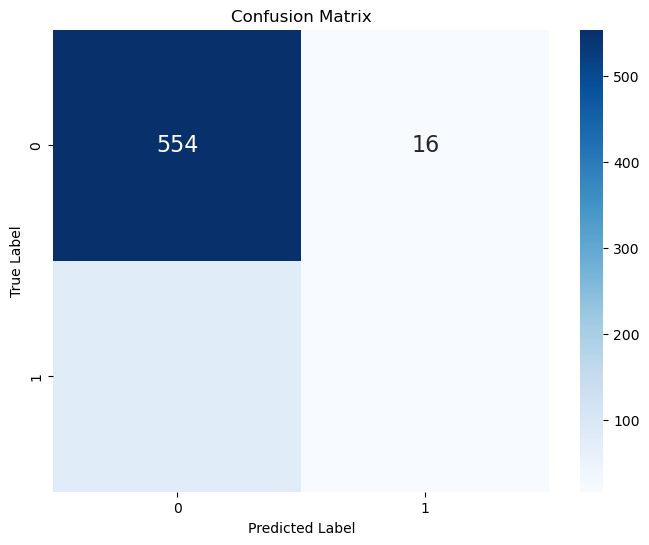


              <-------- Logistic Regression Results --------->
              Accuracy : 85.7571%
              
              Confusion Matrix : [[554  16]
 [ 79  18]]
              
              Classification Report :
                            precision    recall  f1-score   support

           0       0.88      0.97      0.92       570
           1       0.53      0.19      0.27        97

    accuracy                           0.86       667
   macro avg       0.70      0.58      0.60       667
weighted avg       0.82      0.86      0.83       667

              


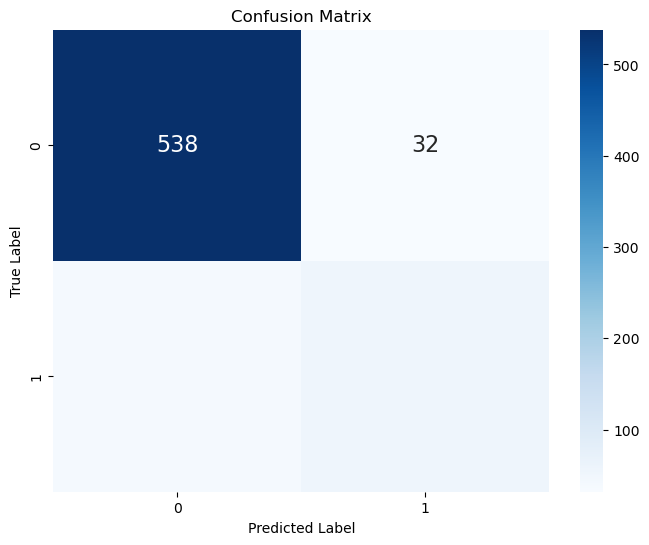


              <-------- Logistic Regression Results --------->
              Accuracy : 89.2054%

              Confusion Matrix : [[538  32]
 [ 40  57]]

              Classification Report :
                            precision    recall  f1-score   support

           0       0.93      0.94      0.94       570
           1       0.64      0.59      0.61        97

    accuracy                           0.89       667
   macro avg       0.79      0.77      0.78       667
weighted avg       0.89      0.89      0.89       667

              
(0.8920539730134932, array([[538,  32],
       [ 40,  57]], dtype=int64), '              precision    recall  f1-score   support\n\n           0       0.93      0.94      0.94       570\n           1       0.64      0.59      0.61        97\n\n    accuracy                           0.89       667\n   macro avg       0.79      0.77      0.78       667\nweighted avg       0.89      0.89      0.89       667\n')


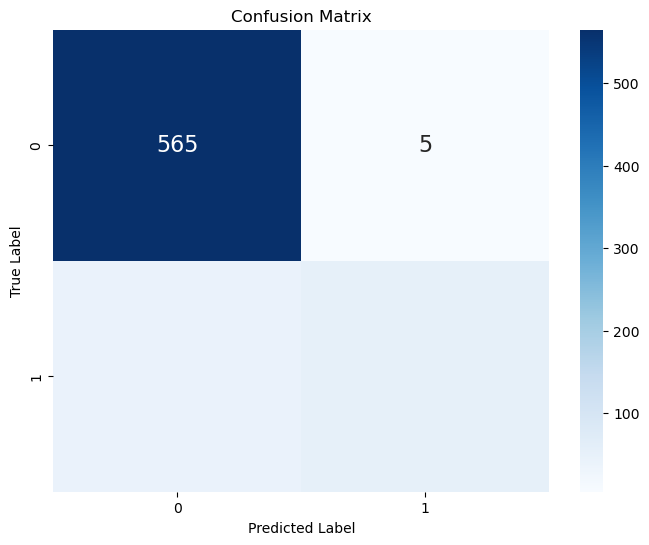


              <-------- Logistic Regression Results --------->
              Accuracy : 92.8036%

              Confusion Matrix : [[565   5]
 [ 43  54]]

              Classification Report :
                            precision    recall  f1-score   support

           0       0.93      0.99      0.96       570
           1       0.92      0.56      0.69        97

    accuracy                           0.93       667
   macro avg       0.92      0.77      0.83       667
weighted avg       0.93      0.93      0.92       667

              
(0.9280359820089955, array([[565,   5],
       [ 43,  54]], dtype=int64), '              precision    recall  f1-score   support\n\n           0       0.93      0.99      0.96       570\n           1       0.92      0.56      0.69        97\n\n    accuracy                           0.93       667\n   macro avg       0.92      0.77      0.83       667\nweighted avg       0.93      0.93      0.92       667\n')
0.9415292353823088


In [27]:
model_0 = Modeling(dataframe=data_analysis.dataframe)

model_0.label_encoder()

# model_0.smote()
X_train, X_test, y_train, y_test = model_0.train_test_split(target_class=("X_train", "y_train"))

model_0.smote(X_train, y_train)

model_0.logistic(X_train, X_test, y_train, y_test)

score1 = model_0.decision_tree(X_train, X_test, y_train, y_test)
print(score1)

score2 = model_0.random_forest(X_train, X_test, y_train, y_test)
print(score2)

score3 = model_0.hyperparameter_tuning(X_train, X_test, y_train, y_test)
print(score3)